# Votes and ICT

- Merge 2016 and 2022 election datasets for the two candidates Marcos and Robredo + ICT data from PSA OpenStat

## Prepare the datasets for merging

In [56]:
import pandas as pd
from pandas_profiling import ProfileReport
from pprint import pprint

elec_2022 = pd.read_csv("../dataset/Elections Dataset/pres_precinct_data_2022.csv")
ict = pd.read_excel("../dataset/ICT_CONTENT_2015_2017.xlsx")
elec_2016 = pd.read_csv("../dataset/Elections Dataset/vp_precinct_data_2016.csv")

# Rename
STDZ_2016 = {
    'barangay': 'Barangay', 
    'province': 'Province', 
    'region': 'Region', 
    'municipality': 'City', 
    'clustered_precinct': 'Precinct ID (2016)',
    'marcos': 'Marcos',
    'robredo': 'Robredo',
}
STDZ_2022 = {
    'barangay': 'Barangay', 
    'province': 'Province', 
    'region': 'Region', 
    'municipality': 'City', 
    'Precinct ID': 'Precinct ID (2022)',
    'MARCOS, BONGBONG (PFP)': 'Marcos',
    'ROBREDO, LENI (IND)': 'Robredo',
}
elec_2016.rename(columns=STDZ_2016, inplace=True)
elec_2022.rename(columns=STDZ_2022, inplace=True)

# Select locations subset w/ Precinct ID
columns_2016 = ['Precinct ID (2016)', 'Region', 'Province', 'City', 'Barangay', 'Marcos', 'Robredo']
columns_2022 = ['Precinct ID (2022)', 'Region', 'Province', 'City', 'Barangay', 'Marcos', 'Robredo']
loc_2016 = pd.DataFrame(elec_2016[columns_2016].sort_index(axis=1).reset_index(drop=True))
loc_2022 = pd.DataFrame(elec_2022[columns_2022].sort_index(axis=1).reset_index(drop=True))

# Abbreviate regions in 2022 dataset
# https://stackoverflow.com/questions/19937362/filter-string-data-based-on-its-string-length
loc_2022.loc[
    loc_2022["Region"].apply(lambda name: len(name.split()) > 2), "Region"
] = loc_2022["Region"].apply(lambda name: "".join([word[0] for word in name.split()]))

# Prepare dataframes for merging
loc_2016.sort_values(by='Precinct ID (2016)', inplace=True)
loc_2022.sort_values(by='Precinct ID (2022)', inplace=True)

# https://stackoverflow.com/questions/40251948/stop-pandas-from-converting-int-to-float-due-to-an-insertion-in-another-column
loc_2016["Precinct ID (2016)"] = pd.Series(loc_2016["Precinct ID (2016)"], dtype=object)
loc_2022["Precinct ID (2022)"] = pd.Series(loc_2022["Precinct ID (2022)"], dtype=object) 

# https://stackoverflow.com/questions/33165734/update-index-after-sorting-data-frame
loc_2016 = loc_2016.reset_index(drop=True)
loc_2022 = loc_2022.reset_index(drop=True)

# Check matched dataframes
print('Shape', loc_2016.shape, loc_2022.shape)
print(loc_2016.columns)
print(loc_2022.columns)

Shape (90642, 7) (105666, 7)
Index(['Barangay', 'City', 'Marcos', 'Precinct ID (2016)', 'Province',
       'Region', 'Robredo'],
      dtype='object')
Index(['Barangay', 'City', 'Marcos', 'Precinct ID (2022)', 'Province',
       'Region', 'Robredo'],
      dtype='object')


## Merge the election dataframes and Validate

In [57]:
merged = pd.merge(
    loc_2016, 
    loc_2022, 
    how="outer",
    left_on=['Precinct ID (2016)'],
    right_on=['Precinct ID (2022)'],
    suffixes=(' (2016)', ' (2022)'),
)

sorter = [
    'Precinct ID (2016)',
    'Precinct ID (2022)',
    'Marcos (2016)',
    'Marcos (2022)',
    'Robredo (2016)',
    'Robredo (2022)',
    'Barangay (2016)',
    'Barangay (2022)',
    'City (2016)',
    'City (2022)',
    'Province (2016)',
    'Province (2022)',
    'Region (2016)',
    'Region (2022)',
]
merged = merged[sorter]

# VALIDATE by comparing to pres and vp pandas profiling reports
profile = ProfileReport(merged, title="Pandas Profiling Report")
# profile.to_file("../reports/Loc - Pandas Profiling Report.html")

## Exploring the ICT dataset

In [79]:
votes_by_region_2016 = elec_2016.groupby(["Region"]).sum()[["Marcos","Robredo"]].reset_index()
votes_by_region_2022 = elec_2022.groupby(["Region"]).sum()[["Marcos","Robredo"]].reset_index()

votes_2016_ict = pd.merge(
    votes_by_region_2016,
    ict,
    how="inner",
    on="Region"
)
votes_2016_ict_num_est = votes_2016_ict[["Region", "Marcos", "Robredo", "Number of establishments 2015", "Number of establishments 2017"]]
votes_2016_ict_num_est

,Region,Marcos,Robredo,Number of establishments 2015,Number of establishments 2017
0,ARMM,283884,464605,NaN,NaN
1,CAR,446960,116213,21.0,21.0
2,NCR,2179053,1361617,346.0,339.0
3,NIR,225922,969381,35.0,NaN
4,REGION I,1764750,297974,35.0,42.0
5,REGION II,1047037,184520,14.0,15.0
6,REGION III,2136431,1334104,32.0,35.0
7,REGION IV-A,1864189,1973116,32.0,40.0
8,REGION IV-B,264650,491405,7.0,8.0
9,REGION IX,315547,474021,25.0,29.0


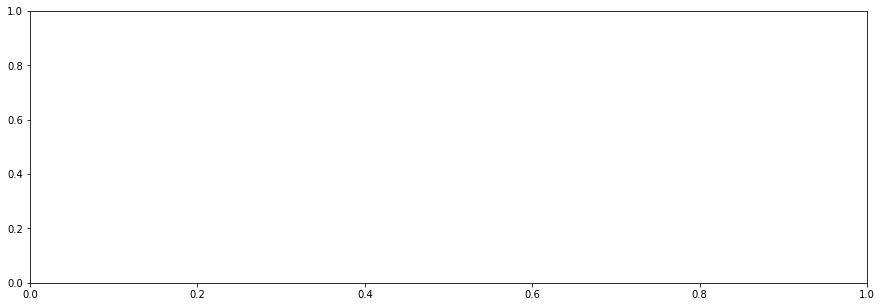

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(votes_2016_ict_num_est)

<AxesSubplot:>

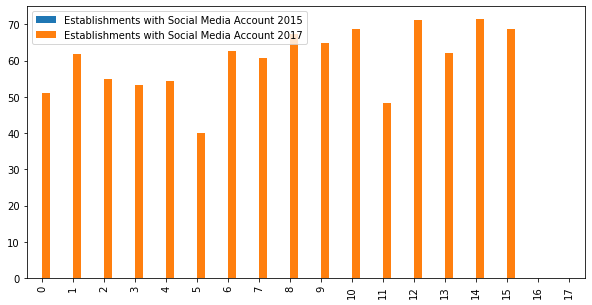

In [60]:
# Values in the this dataset are in percent except number of establishments and employment

# ict[["Region", "Establishments with internet access 2015", "Establishments with internet access 2017"]].plot.bar(figsize=(10,5))
ict[["Region", "Establishments with Social Media Account 2015", "Establishments with Social Media Account 2017"]].plot.bar(figsize=(10,5))
# ict.dtypes